# Домашнее задание 2 - Локализация ключевых точек
<br>

Задание выполнил(а): Зосимов Савва Орестьевич
<br>

**Дедлайн:** 26.04.2021 23:59


### О задании
В этом задании вы познакомитесь с функционалом SAS для реализации сетей локализации ключевых точек, а так же построите и обучите такую сеть самостоятельно.
<br>

**Задание построено следующим образом:**<br>
1) Задание 1: Загрузка данных в CAS - 1 балл<br>
2) Задание 2: Соединение таблиц - 3 балла<br>
3) Задание 3: Подготовка данных для обучения - 2 балла<br>
4) Задание 4: Построение модели - 4 балла<br>
5) Задание 5: Обучение модели - 2 балла<br>
6) Задание 6: Проверка и визуализация результатов работы сети - 3 балла<br>
7) Задание 7 (дополнительное) - до +2 баллов

### Формат сдачи

После того, как вы выполните домашную работу, поместите jupyter notebook с выполнеными заданиями (output всех ячеек должен сохранится) в закрытый git-репозиторий на GitHub. Предоставьте доступ к репозиторию аккаунтам GazizovMarat и Ala1s (добавив в свой репозиторий в качестве коллабораторов).

### Важно 
Для того, чтобы ваши результаты были воспроизводимыми для проверки, указывайте seed при вызове методов, где это возможно. Напоминания об этом так же содержатся в тексте заданий.

In [165]:
import os
import numpy as np
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

from glob import glob
from tqdm import tqdm

from swat import *
from dlpy import Model, Sequential

from dlpy.layers import *
from dlpy.images import ImageTable
from dlpy.splitting import three_way_split

**Подключение к серверу CAS**<br>
Подключитесь к серверу CAS под своим логином и паролем.<br>
Загрузите следующие Action Sets: 'image' и 'deepLearn'.<br>

In [166]:
#os.environ['CAS_CLIENT_SSL_CA_LIST'] = r"/tmp/4fix/trustedcerts.pem"

# Создаем новую сессию CAS:
# Ваш код здесь
s = CAS('tiger.cs.msu.ru', 5570, username='msu95', password='DarWin##D4')
# Загружаем action sets:
# Ваш код здесь
s.loadactionset('image')
s.loadactionset('deepLearn')

NOTE: Added action set 'image'.
NOTE: Added action set 'deepLearn'.


[actionset]

 'deepLearn'

+ Elapsed: 0.00902s, user: 0.00114s, sys: 0.00715s, mem: 0.252mb

**Набор данных**<br>
Вам предлагается набор данных с фотографиями кошек. Сами фотографии располагаются в папке images. Для каждой фотографии имеется разметка, содержащяя координаты 9 ключевых точек мордочки кошки, точки в разметке представлены через пробел в следующем порядке:
- Number of points (default is 9)
- Left Eye
- Right Eye
- Mouth
- Left Ear-1
- Left Ear-2
- Left Ear-3
- Right Ear-1
- Right Ear-2
- Right Ear-3

<br>
Пример изображения:<br>

![cat](cat1.PNG)

<br>
Первое число - количество точек, оно нам не потребуется.<br>
Разметка для каждого изображения находится в отдельном файле, все эти файлы с разметкой содержатся в папке points. Название каждого такого файла совпадает с названием изображения, но имеют расширение '.cat', но не переживайте - это простые текстовые файлы. <br>
Пример:<br>
Название файла изображения - 00000001_000.jpg <br>
Название файла с разметкой - 00000001_000.jpg.cat

**Задание 1: Загрузка данных в CAS**<br><br>
a) Перед тем, как использовать набор данных, потребуется решить несколько проблем с ним. <br><br>
Во-первых, для того чтобы загрузить разметку в CAS потребуется сформировать из них таблицу. Дополните код ниже, чтобы сделать это. <br><br>
Заметьте, что одна из строчек кода, уже написанного за вас, помогает отсеивать разметку, в которой не все ключевые точки присутствуют на изображении - в таком случае в разметке присутствуют отрицательные числа. Такие примеры нам не потребуются, поэтому код, сохраняющий разметку для изображений, напишите внутри этого блока if.

In [55]:
points_data = []
a_path = '/var/home/msu95/SAS-CV-2020-Homework2/cats/points/*.cat' #Пропишите здесь путь к папке с аннотациями
for path in glob(a_path):
    with open(path,'r') as f:
        points = f.read().split(' ')[1:-1]
        points = [int(x) for x in points]
        if any(x<0 for x in points) == False:
            #Ваш код здесь
            keypoints_1d = np.array(points[0:]) 
            keypoints_xy = keypoints_1d.reshape((-1, 18))
            keypoints_list = keypoints_xy.tolist()
            filename = os.path.basename(f.name)[:-4]
            keypoints_list[0].insert(0,filename)
            points_data.extend(keypoints_list)
print(points_data)



[['00000001_000.jpg', 175, 160, 239, 162, 199, 199, 149, 121, 137, 78, 166, 93, 281, 101, 312, 96, 296, 133], ['00000001_008.jpg', 318, 222, 340, 224, 327, 238, 301, 199, 304, 182, 321, 196, 341, 197, 359, 183, 361, 203], ['00000001_011.jpg', 167, 173, 242, 185, 191, 247, 112, 105, 118, 0, 171, 74, 270, 90, 353, 35, 332, 147], ['00000001_012.jpg', 115, 122, 179, 121, 133, 169, 95, 70, 93, 17, 131, 46, 233, 39, 281, 9, 224, 69], ['00000001_016.jpg', 375, 263, 436, 260, 409, 296, 332, 226, 319, 157, 363, 186, 439, 179, 472, 146, 475, 215], ['00000001_017.jpg', 410, 464, 511, 344, 568, 494, 222, 473, 113, 370, 288, 359, 380, 250, 337, 75, 476, 200], ['00000001_020.jpg', 225, 125, 337, 139, 250, 200, 186, 93, 169, 12, 237, 60, 360, 79, 462, 51, 411, 124], ['00000001_024.jpg', 278, 121, 347, 121, 317, 179, 228, 79, 220, 12, 282, 61, 339, 60, 397, 16, 387, 76], ['00000001_027.jpg', 229, 142, 273, 147, 247, 171, 210, 109, 197, 85, 230, 98, 291, 103, 327, 80, 301, 116], ['00000001_029.jpg', 37

In [167]:
labels = ['_filename_0',
'left_eye_x','left_eye_y',
'right_eye_x','right_eye_y',
'mouth_x','mouth_y',
'left_ear1_x','left_ear1_y',
'left_ear2_x','left_ear2_y',
'left_ear3_x','left_ear3_y',
'right_ear1_x','right_ear1_y',
'right_ear2_x','right_ear2_y',
'right_ear3_x','right_ear3_y']

In [57]:
data = pd.DataFrame.from_records(points_data, columns = labels) 
# Ваш код здесь
print(data.loc[data['_filename_0'] == '60001365_021.jpg'])
data.tail(25)


Empty DataFrame
Columns: [_filename_0, left_eye_x, left_eye_y, right_eye_x, right_eye_y, mouth_x, mouth_y, left_ear1_x, left_ear1_y, left_ear2_x, left_ear2_y, left_ear3_x, left_ear3_y, right_ear1_x, right_ear1_y, right_ear2_x, right_ear2_y, right_ear3_x, right_ear3_y]
Index: []


,_filename_0,left_eye_x,left_eye_y,right_eye_x,right_eye_y,mouth_x,mouth_y,left_ear1_x,left_ear1_y,left_ear2_x,left_ear2_y,left_ear3_x,left_ear3_y,right_ear1_x,right_ear1_y,right_ear2_x,right_ear2_y,right_ear3_x,right_ear3_y
8980,60001496_008.jpg,186,161,253,179,193,215,173,132,192,46,221,114,278,131,345,96,322,177
8981,60001496_009.jpg,136,94,192,92,167,122,103,95,100,30,138,61,183,61,215,27,220,91
8982,60001496_010.jpg,149,142,216,139,188,196,102,113,99,33,153,80,201,78,251,29,249,108
8983,60001496_012.jpg,237,189,327,225,273,292,154,122,213,0,251,91,333,129,411,97,356,208
8984,60001496_013.jpg,222,219,329,222,271,310,103,123,109,9,186,70,354,78,441,12,382,132
8985,60001496_016.jpg,277,201,379,209,321,293,234,144,228,50,297,112,366,119,444,56,423,162
8986,60001496_021.jpg,130,209,161,213,141,233,113,191,120,153,138,178,162,182,188,164,185,203
8987,60001496_024.jpg,759,128,849,129,808,182,699,120,688,21,758,71,839,73,916,27,894,124
8988,60001496_029.jpg,419,324,581,322,501,454,259,250,243,19,395,150,564,152,728,48,675,248
8989,60001497_018.jpg,225,569,352,535,316,665,159,438,36,311,192,364,339,328,449,228,353,392


b) Также, все координаты ключевых точек указаны в абсолютных коорданатах - соотвественно, если мы изменим размер изображения, координаты ключевых точек придётся пересчитывать. Давайте переведем их в относительные координаты - для этого потребуется поделить координаты по x на ширину изображения, а координаты по y на высоту изображения. Обратите внимание, что все изображения различного размера. Также обратите внимание на тип данных столбцов в dataframe - если тип целочисленный, то посчитанные вами значения будут округляться к нулю или единице, что, конечно же, неверно.  

In [58]:
# Ваш код здесь
filenames = data['_filename_0'].tolist()
path = '/var/home/msu95/SAS-CV-2020-Homework2/cats/images/'
path += '% s'
filenames = [path % i for i in filenames]
#print(filenames)
sizes = [[cv2.imread(filename).shape[0],cv2.imread(filename).shape[1]] for filename in filenames]
heights, widths = map(list,zip(*sizes))
#images = list(map(lambda x: cv2.imread(x),filenames))
#heights = list(map(lambda h: h.shape[0], images ))
#widths = list(map(lambda w: w.shape[1], images ))
for column in data.columns[1:]:
    if (column[len(column)-1] == 'y'):        
        data[column] /= heights
    elif (column[len(column)-1] == 'x'):
        data[column] /= widths
data.head(10)
#print(data.loc[data['_filename_0']=='00000338_013.jpg'])            

,_filename_0,left_eye_x,left_eye_y,right_eye_x,right_eye_y,mouth_x,mouth_y,left_ear1_x,left_ear1_y,left_ear2_x,left_ear2_y,left_ear3_x,left_ear3_y,right_ear1_x,right_ear1_y,right_ear2_x,right_ear2_y,right_ear3_x,right_ear3_y
0,00000001_000.jpg,0.466667,0.320000,0.637333,0.324000,0.530667,0.398000,0.397333,0.242000,0.365333,0.156000,0.442667,0.186000,0.749333,0.202000,0.832000,0.192000,0.789333,0.266000
1,00000001_008.jpg,0.636000,0.592000,0.680000,0.597333,0.654000,0.634667,0.602000,0.530667,0.608000,0.485333,0.642000,0.522667,0.682000,0.525333,0.718000,0.488000,0.722000,0.541333
2,00000001_011.jpg,0.334000,0.461333,0.484000,0.493333,0.382000,0.658667,0.224000,0.280000,0.236000,0.000000,0.342000,0.197333,0.540000,0.240000,0.706000,0.093333,0.664000,0.392000
3,00000001_012.jpg,0.230000,0.366366,0.358000,0.363363,0.266000,0.507508,0.190000,0.210210,0.186000,0.051051,0.262000,0.138138,0.466000,0.117117,0.562000,0.027027,0.448000,0.207207
4,00000001_016.jpg,0.366211,0.386197,0.425781,0.381791,0.399414,0.434655,0.324219,0.331865,0.311523,0.230543,0.354492,0.273128,0.428711,0.262849,0.460938,0.214391,0.463867,0.315712
5,00000001_017.jpg,0.400391,0.551069,0.499023,0.408551,0.554688,0.586698,0.216797,0.561758,0.110352,0.439430,0.281250,0.426366,0.371094,0.296912,0.329102,0.089074,0.464844,0.237530
6,00000001_020.jpg,0.450000,0.333333,0.674000,0.370667,0.500000,0.533333,0.372000,0.248000,0.338000,0.032000,0.474000,0.160000,0.720000,0.210667,0.924000,0.136000,0.822000,0.330667
7,00000001_024.jpg,0.556000,0.363363,0.694000,0.363363,0.634000,0.537538,0.456000,0.237237,0.440000,0.036036,0.564000,0.183183,0.678000,0.180180,0.794000,0.048048,0.774000,0.228228
8,00000001_027.jpg,0.458000,0.426426,0.546000,0.441441,0.494000,0.513514,0.420000,0.327327,0.394000,0.255255,0.460000,0.294294,0.582000,0.309309,0.654000,0.240240,0.602000,0.348348
9,00000001_029.jpg,0.754000,0.276961,0.884000,0.274510,0.822000,0.404412,0.686000,0.171569,0.654000,0.012255,0.756000,0.098039,0.870000,0.098039,0.938000,0.017157,0.946000,0.171569


c) Сохраните набор данных в формате csv, а затем загрузите эту таблицу в CAS с помощью функции upload_file.

In [59]:
# Ваш код здесь
data.to_csv('kp2.csv')
points_table = s.upload_file('kp2.csv')

NOTE: Cloud Analytic Services made the uploaded file available as table KP2 in caslib CASUSER(msu95).
NOTE: The table KP2 has been created in caslib CASUSER(msu95) from binary data uploaded to Cloud Analytic Services.


d) Создайте список названий переменных, в которых лежат координаты ключевых точек - он нам понадобится в дальнейшем.

In [60]:
# Ваш код здесь
keypoints_names = labels[1:]
print(keypoints_names)


['left_eye_x', 'left_eye_y', 'right_eye_x', 'right_eye_y', 'mouth_x', 'mouth_y', 'left_ear1_x', 'left_ear1_y', 'left_ear2_x', 'left_ear2_y', 'left_ear3_x', 'left_ear3_y', 'right_ear1_x', 'right_ear1_y', 'right_ear2_x', 'right_ear2_y', 'right_ear3_x', 'right_ear3_y']


e) Загрузите изображения из папки images в ImageTable.

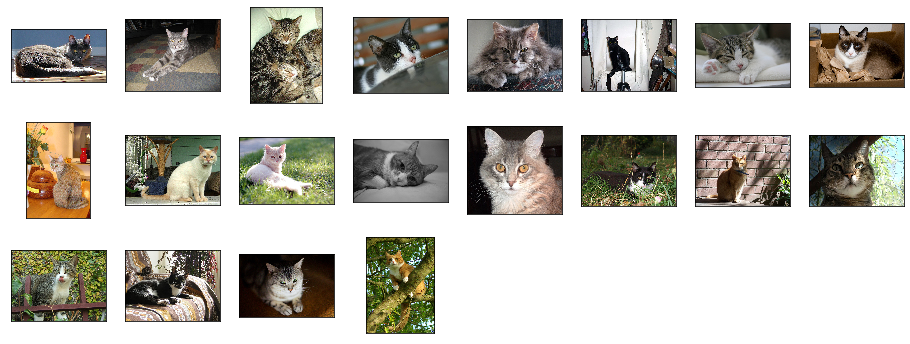

,_image_,_label_,_filename_0,_id_
0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...,,00000041_000.jpg,310
1,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...,,00000344_017.jpg,965
2,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...,,00000088_025.jpg,602
3,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...,,00000344_019.jpg,966
4,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...,,00000041_001.jpg,311
5,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...,,00000344_020.jpg,967
6,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...,,00000344_024.jpg,968
7,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...,,00000041_003.jpg,312
8,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...,,00000041_007.jpg,313
9,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...,,00000344_026.jpg,969


In [61]:
# Ваш код здесь
images = ImageTable.load_files(s,path ='/var/home/msu95/SAS-CV-2020-Homework2/cats/images/')
images.show(20, randomize = False)
images.head(10)


**Задание 2: Соединение таблиц**<br><br>
a) Соедините таблицу с изображениями и таблицу с казметкой с помощью action dlJoin. 
b) Затем с помощью конструктора ImageTable.from_table превратите уже соединенную таблицу в ImageTable для дальнейшей работы с ней.

In [63]:
# a)
# Ваш код здесь
s.dljoin(annotatedTable = images , table = points_table , casOut = dict(name='merged_tbl', replace=True) , id = '_filename_0')
merged_table = s.CASTable('merged_tbl')
merged_table.head(50)

,_filename_0,Var1,left_eye_x,left_eye_y,right_eye_x,right_eye_y,mouth_x,mouth_y,left_ear1_x,left_ear1_y,...,left_ear3_y,right_ear1_x,right_ear1_y,right_ear2_x,right_ear2_y,right_ear3_x,right_ear3_y,_image_,_label_,_id_
0,10000150_006.jpg,1952.0,0.415039,0.376025,0.583984,0.362705,0.503906,0.500000,0.282227,0.351434,...,0.228484,0.573242,0.219262,0.668945,0.095287,0.690430,0.321721,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...,,2128
1,10000150_012.jpg,1953.0,0.357247,0.301758,0.572474,0.309570,0.462665,0.427734,0.202050,0.246094,...,0.179688,0.572474,0.184570,0.836018,0.091797,0.743777,0.261719,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...,,2132
2,10000150_013.jpg,1954.0,0.715820,0.405564,0.787109,0.407028,0.753906,0.496340,0.660156,0.366032,...,0.307467,0.787109,0.307467,0.865234,0.234261,0.841797,0.363104,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...,,2133
3,10000150_014.jpg,1955.0,0.400433,0.232000,0.528139,0.226000,0.482684,0.346000,0.225108,0.204000,...,0.130000,0.549784,0.118000,0.675325,0.020000,0.623377,0.184000,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...,,2134
4,10000150_017.jpg,1956.0,0.374000,0.418667,0.502000,0.426667,0.480000,0.557333,0.200000,0.322667,...,0.232000,0.466000,0.253333,0.566000,0.181333,0.530000,0.346667,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...,,2135
5,10000150_020.jpg,1957.0,0.468750,0.235412,0.528320,0.227364,0.505859,0.325956,0.434570,0.181087,...,0.130785,0.520508,0.122736,0.572266,0.038229,0.564453,0.167002,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...,,2136
6,10000150_029.jpg,1958.0,0.346000,0.514667,0.464000,0.770667,0.218000,0.770667,0.450000,0.240000,...,0.261333,0.750000,0.565333,0.918000,0.637333,0.674000,0.818667,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...,,2137
7,10000151_004.jpg,1959.0,0.395480,0.266000,0.627119,0.284000,0.497175,0.370000,0.237288,0.256000,...,0.118000,0.683616,0.146000,0.841808,0.134000,0.785311,0.302000,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...,,2139
8,10000151_005.jpg,1960.0,0.397531,0.370000,0.654321,0.372000,0.535802,0.498000,0.207407,0.354000,...,0.180000,0.706173,0.184000,0.896296,0.172000,0.814815,0.358000,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...,,2140
9,10000151_007.jpg,1961.0,0.588000,0.538667,0.642000,0.525333,0.622000,0.597333,0.544000,0.496000,...,0.461333,0.630000,0.450667,0.670000,0.378667,0.680000,0.461333,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...,,2141


In [67]:
# b)
imgTbl = ImageTable.from_table(s.CASTable('merged_tbl') , image_col = '_image_' ,columns = keypoints_names)
imgTbl.tail(20)

,_image_,_label_,_filename_0,_id_,left_eye_x,left_eye_y,right_eye_x,right_eye_y,mouth_x,mouth_y,...,left_ear2_x,left_ear2_y,left_ear3_x,left_ear3_y,right_ear1_x,right_ear1_y,right_ear2_x,right_ear2_y,right_ear3_x,right_ear3_y
8985,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...,,00000084_010.jpg,581,0.522000,0.498667,0.670000,0.496000,0.596000,0.656000,...,0.384000,0.128000,0.538000,0.304000,0.654000,0.304000,0.810000,0.130667,0.796000,0.461333
8986,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...,,00000340_028.jpg,942,0.466000,0.429333,0.684000,0.469333,0.574000,0.677333,...,0.304000,0.005333,0.448000,0.176000,0.668000,0.221333,0.850000,0.093333,0.798000,0.397333
8987,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...,,00000092_016.jpg,626,0.718000,0.320930,0.788000,0.316279,0.762000,0.423256,...,0.672000,0.060465,0.718000,0.181395,0.782000,0.181395,0.816000,0.051163,0.814000,0.241860
8988,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...,,00000347_001.jpg,984,0.558000,0.536000,0.538000,0.674667,0.468000,0.584000,...,0.758000,0.498667,0.664000,0.576000,0.646000,0.690667,0.704000,0.818667,0.572000,0.794667
8989,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...,,00000447_015.jpg,1644,0.452000,0.420000,0.586000,0.428000,0.512000,0.530000,...,0.380000,0.188000,0.474000,0.294000,0.576000,0.302000,0.684000,0.212000,0.672000,0.366000
8990,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...,,00000089_016.jpg,608,0.614925,0.300000,0.734328,0.300000,0.674627,0.356000,...,0.552239,0.178000,0.632836,0.234000,0.737313,0.236000,0.829851,0.176000,0.814925,0.270000
8991,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...,,40000917_024.jpg,6018,0.346000,0.279133,0.456000,0.281843,0.396000,0.392954,...,0.258000,0.056911,0.340000,0.102981,0.472000,0.105691,0.548000,0.048780,0.544000,0.184282
8992,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...,,00000304_018.jpg,710,0.398000,0.570571,0.586000,0.570571,0.498000,0.768769,...,0.266000,0.084084,0.404000,0.264264,0.568000,0.267267,0.726000,0.099099,0.712000,0.420420
8993,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...,,00000042_009.jpg,316,0.358000,0.464208,0.602000,0.472885,0.460000,0.689805,...,0.210000,0.030369,0.396000,0.197397,0.580000,0.206074,0.774000,0.047722,0.746000,0.342733
8994,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...,,00000017_008.jpg,139,0.790039,0.262654,0.846680,0.352941,0.775391,0.388509,...,0.833008,0.016416,0.835938,0.149111,0.897461,0.251710,0.991211,0.272230,0.892578,0.329685


**Задание 3: Подготовка данных для обучения**<br><br>
а) Измените размер изображений на 96x96 с помощью функции resize ImageTable.<br>
b) Перемешайте данные с помощью функции action shuffle.<br>
c) Разделите набор данных на обучающий, валидационный и тестовых с помощью функции three_way_split. Процент данных в валидационном наборе данных - 20%, в тестовом - 20%.<br>

In [68]:
# a)
resized_imgTbl = imgTbl.resize(width = 96, height = 96, inplace = False, columns = keypoints_names)
resized_imgTbl.image_summary
resized_imgTbl.tail(20)

,_filename_0,right_ear3_x,right_eye_y,mouth_x,mouth_y,left_ear1_y,left_ear1_x,left_ear3_x,right_ear2_x,left_ear2_y,...,left_eye_x,left_eye_y,right_ear1_x,right_ear1_y,right_ear3_y,left_ear2_x,left_ear3_y,_image_,_id_,_label_
8985,10000256_006.jpg,0.729492,0.563690,0.477539,0.836018,0.368960,0.257812,0.398438,0.762695,0.023426,...,0.374023,0.551977,0.586914,0.254758,0.390922,0.246094,0.248902,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,3002,
8986,30000807_006.jpg,0.536000,0.418667,0.402000,0.448000,0.280000,0.376000,0.396000,0.558000,0.200000,...,0.390000,0.384000,0.504000,0.330667,0.378667,0.364000,0.264000,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,5151,
8987,60001339_005.jpg,0.861333,0.356000,0.512000,0.528000,0.426000,0.365333,0.469333,0.909333,0.124000,...,0.418667,0.376000,0.653333,0.216000,0.372000,0.216000,0.236000,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,8886,
8988,10000189_024.jpg,0.454819,0.308000,0.343373,0.352000,0.260000,0.265060,0.319277,0.454819,0.194000,...,0.307229,0.304000,0.388554,0.236000,0.272000,0.259036,0.232000,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,2459,
8989,00000092_013.jpg,0.748000,0.392000,0.672000,0.450667,0.384000,0.594000,0.622000,0.746000,0.301333,...,0.636000,0.402667,0.704000,0.330667,0.360000,0.570000,0.344000,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,625,
8990,40001010_004.jpg,0.694000,0.370023,0.568000,0.557377,0.271663,0.280000,0.426000,0.746000,0.039813,...,0.450000,0.400468,0.602000,0.145199,0.222482,0.264000,0.166276,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,6643,
8991,20000519_010.jpg,0.708008,0.528646,0.655273,0.738281,0.570312,0.376953,0.476562,0.697266,0.317708,...,0.515625,0.604167,0.602539,0.364583,0.423177,0.305664,0.414062,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,3528,
8992,40001027_006.jpg,0.428000,0.365333,0.310000,0.496000,0.280000,0.130000,0.218000,0.448000,0.090667,...,0.232000,0.365333,0.368000,0.202667,0.288000,0.126000,0.202667,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,6764,
8993,50001193_005.jpg,0.500000,0.381333,0.388000,0.480000,0.328000,0.256000,0.332000,0.480000,0.197333,...,0.332000,0.394667,0.410000,0.229333,0.301333,0.240000,0.237333,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,7922,
8994,10000164_026.jpg,0.855856,0.436000,0.549550,0.560000,0.346000,0.300300,0.450450,0.900901,0.194000,...,0.438438,0.434000,0.690691,0.302000,0.350000,0.276276,0.298000,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,2247,


In [69]:
# b)
# Ваш код здесь
s.shuffle(table = resized_imgTbl , casOut = dict(name='shuffled_tbl', replace=True))

print(s.CASTable('shuffled_tbl').numrows()["numrows"])
s.CASTable('shuffled_tbl').head(10)

9005


,_filename_0,right_ear3_x,right_eye_y,mouth_x,mouth_y,left_ear1_y,left_ear1_x,left_ear3_x,right_ear2_x,left_ear2_y,...,left_eye_x,left_eye_y,right_ear1_x,right_ear1_y,right_ear3_y,left_ear2_x,left_ear3_y,_image_,_id_,_label_
0,10000161_014.jpg,0.486486,0.270000,0.339339,0.344000,0.226000,0.189189,0.276276,0.504505,0.128000,...,0.270270,0.268000,0.399399,0.184000,0.226000,0.174174,0.184000,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,2219,
1,60001496_009.jpg,0.660661,0.184000,0.501502,0.244000,0.190000,0.309309,0.414414,0.645646,0.060000,...,0.408408,0.188000,0.549550,0.122000,0.182000,0.300300,0.122000,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,9970,
2,50001163_003.jpg,0.886000,0.327327,0.746000,0.423423,0.216216,0.632000,0.720000,0.924000,0.033033,...,0.706000,0.297297,0.820000,0.183183,0.291291,0.658000,0.156156,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,7709,
3,60001317_000.jpg,0.716000,0.420420,0.538000,0.591592,0.321321,0.422000,0.494000,0.724000,0.078078,...,0.486000,0.414414,0.632000,0.234234,0.330330,0.394000,0.225225,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,8756,
4,60001464_023.jpg,0.690808,0.258789,0.512535,0.333984,0.263672,0.299443,0.427577,0.679666,0.089844,...,0.427577,0.261719,0.564067,0.176758,0.256836,0.281337,0.175781,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,9742,
5,20000671_028.jpg,0.896000,0.433121,0.766000,0.570064,0.292994,0.634000,0.728000,0.914000,0.089172,...,0.716000,0.410828,0.824000,0.245223,0.350318,0.656000,0.226115,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,4853,
6,00000393_022.jpg,0.710000,0.767442,0.554000,0.909561,0.687339,0.392000,0.480000,0.772000,0.509044,...,0.488000,0.762274,0.636000,0.596899,0.702842,0.356000,0.591731,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,1307,
7,60001465_000.jpg,0.592000,0.418667,0.516000,0.594667,0.357333,0.262000,0.430000,0.612000,0.066667,...,0.398000,0.424000,0.502000,0.253333,0.357333,0.294000,0.253333,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,9744,
8,10000186_024.jpg,0.604492,0.485677,0.413086,0.623698,0.279948,0.374023,0.466797,0.605469,0.102865,...,0.382812,0.457031,0.535156,0.234375,0.343750,0.339844,0.214844,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,2431,
9,00000348_002.jpg,0.588000,0.525526,0.490000,0.624625,0.492492,0.350000,0.402000,0.560000,0.330330,...,0.428000,0.555556,0.508000,0.360360,0.420420,0.330000,0.393393,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,991,


In [151]:
# c)
# Ваш код здесь
train_data, val_data, test_data = three_way_split(s.CASTable('shuffled_tbl'), valid_rate=20, test_rate=20, seed = 42, im_table = False)

print("Number of images in train_data:", train_data.numrows()["numrows"])
print("Number of images in validation_data:", val_data.numrows()["numrows"])
print("Number of images in test_data:", test_data.numrows()["numrows"])
train_data.head(10)

Number of images in train_data: 5403
Number of images in validation_data: 1801
Number of images in test_data: 1801


,_filename_0,right_ear3_x,right_eye_y,mouth_x,mouth_y,left_ear1_y,left_ear1_x,left_ear3_x,right_ear2_x,left_ear2_y,...,left_eye_x,left_eye_y,right_ear1_x,right_ear1_y,right_ear3_y,left_ear2_x,left_ear3_y,_image_,_id_,_label_
0,20000549_024.jpg,0.690000,0.314667,0.604000,0.402667,0.234667,0.496000,0.570000,0.728000,0.098667,...,0.562000,0.298667,0.650000,0.202667,0.272000,0.522000,0.189333,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,3805,
1,40001038_014.jpg,0.610352,0.370262,0.566406,0.486880,0.462099,0.423828,0.443359,0.520508,0.309038,...,0.497070,0.435860,0.513672,0.250729,0.288630,0.360352,0.317784,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,6832,
2,60001314_011.jpg,0.385742,0.464730,0.309570,0.553250,0.439834,0.207031,0.240234,0.402344,0.356846,...,0.257812,0.471646,0.333984,0.380360,0.431535,0.193359,0.384509,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,8737,
3,60001384_013.jpg,0.754000,0.594667,0.694000,0.637333,0.424000,0.632000,0.706000,0.834000,0.312000,...,0.696000,0.536000,0.768000,0.506667,0.586667,0.696000,0.424000,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,9161,
4,40000941_016.jpg,0.494000,0.150602,0.406000,0.207831,0.150602,0.370000,0.400000,0.484000,0.054217,...,0.388000,0.159639,0.446000,0.090361,0.135542,0.366000,0.096386,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,6176,
5,40001065_018.jpg,0.858398,0.204027,0.738281,0.288591,0.163758,0.683594,0.726562,0.853516,0.036242,...,0.712891,0.206711,0.799805,0.091275,0.163758,0.661133,0.091275,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,7042,
6,00000349_021.jpg,0.864000,0.492492,0.642000,0.750751,0.489489,0.350000,0.476000,0.860000,0.114114,...,0.508000,0.513514,0.686000,0.258258,0.441441,0.284000,0.276276,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,1002,
7,00000079_026.jpg,0.651367,0.453039,0.501953,0.638122,0.379834,0.326172,0.405273,0.672852,0.168508,...,0.416016,0.465470,0.569336,0.266575,0.366022,0.286133,0.274862,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,564,
8,60001309_004.jpg,0.472000,0.344311,0.336000,0.458084,0.263473,0.212000,0.268000,0.492000,0.131737,...,0.288000,0.344311,0.404000,0.197605,0.263473,0.178000,0.197605,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,8700,
9,40001043_025.jpg,0.640000,0.466667,0.516000,0.589333,0.373333,0.400000,0.488000,0.642000,0.224000,...,0.468000,0.461333,0.572000,0.317333,0.384000,0.422000,0.314667,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,6865,


**Задание 4: Построение модели**<br><br>
Постройте модель CNN, схема которой изображена на картинке. Особенности модели не отраженные на рисунке: в слое Conv предшествующем BatchNormalization отсутствуют bias, а в Dense слое присутствует дропаут с вероятностью 0.2. Полученная вами сеть должна показывать Loss Error на тестовом наборе данных более 0.21.
![model](kpnetwork.PNG)

In [71]:
model = Sequential(s, model_table='cnn_model')
model.add(InputLayer(1,96,96, name = 'input'))
# Ваш код здесь
model.add(Conv2d(72,4))
model.add(Pooling(2))
model.add(Conv2d(48,2,include_bias=False))
model.add(BN())
model.add(Dense(48, dropout = 0.2))
model.add(Keypoints(n=18, name='kp1'))
model.print_summary()

NOTE: Input layer added.
NOTE: Convolution layer added.
NOTE: Pooling layer added.
NOTE: Convolution layer added.
NOTE: Batch normalization layer added.
NOTE: Fully-connected layer added.
NOTE: Keypoints layer added.
NOTE: Model compiled successfully.


,Layer Id,Layer,Type,Kernel Size,Stride,Activation,Output Size,Number of Parameters,FLOPS(forward pass)
0,0,input,input,,,None,"(96, 96, 1)","(0, 0)",0
1,1,Convo.1,convo,"(4, 4)","(1, 1)",Relu,"(96, 96, 72)","(1152, 72)",10616832
2,2,Pool1,pool,"(2, 2)","(2, 2)",Max,"(48, 48, 72)","(0, 0)",0
3,3,Convo.2,convo,"(2, 2)","(1, 1)",Relu,"(48, 48, 48)","(13824, 0)",31850496
4,4,B.N.1,batchnorm,,,Auto,"(48, 48, 48)","(0, 96)",0
5,5,F.C.1,fc,"(110592, 48)",,Relu,48,"(5308416, 0)",5308416
6,6,kp1,keypoints,"(48, 18)",,Auto,18,"(864, 18)",0
7,,,,,,,,Total number of parameters,Total FLOPS
8,Summary,,,,,,,"5,324,442","47,775,744"


**Задание 5: Обучение модели**<br><br>
Обучите модель, дополнив код ниже. Формат входных данных в model.fit укажите с помощью параметра data_specs.

In [74]:
from dlpy.model import *
from dlpy.model import Optimizer

#Подберите самостоятельно
lr_ = 0.001

optimizer = Optimizer(mini_batch_size=12, log_level=2, max_epochs=20, reg_l2=0.0005,
                      algorithm=MomentumSolver(clip_grad_max=1000, clip_grad_min=-1000,
                                               learning_rate=lr_, step_size=30))

dataOpts = [DataSpec(type_='IMAGE', layer='input', data=['_image_']),DataSpec(type_='numnom', layer='kp1', data=keypoints_names)]
train_history = model.fit(data = train_data , data_specs = dataOpts, valid_table = val_data, lr = lr_ , optimizer = optimizer,
                         record_seed=13309 ,seed=42)

NOTE: Training from scratch.
NOTE:  Synchronous mode is enabled.
NOTE:  The total number of parameters is 5324490.
NOTE:  The approximate memory cost is 5153.00 MB.
NOTE:  Loading weights cost       0.00 (s).
NOTE:  Initializing each layer cost       0.70 (s).
NOTE:  The total number of threads on each worker is 40.
NOTE:  The total mini-batch size per thread on each worker is 12.
NOTE:  The maximum mini-batch size across all workers for the synchronous mode is 480.
NOTE:  Number of input variables:     1
NOTE:  Number of numeric input variables:      1
NOTE:  Epoch Learning Rate        Loss  Fit Error  Validation Loss Validation Error   Time(s)
NOTE:  0         0.001            2.98      5.961            1.753            3.505    22.47
NOTE:  1         0.001           1.649      3.299            1.458            2.916    22.34
NOTE:  2         0.001           1.333      2.666            1.176            2.352    22.01
NOTE:  3         0.001           1.077      2.153           0.9445 

**Задание 6: Проверка и визуализация результатов работы сети**<br><br>
a) Получите предсказания на тестовом наборе данных c помощью функции predict.<br>
b) Дополните код функции plot_landmarks, предназначенной для визуализации предсказаний модели. С помощью вызова этой функции отоборазите результаты из тестового набора данных.

In [75]:
# a)
# Ваш код здесь
model.predict(data=test_data)

[ScoreInfo]

                          Descr         Value
 0  Number of Observations Read          1801
 1  Number of Observations Used          1801
 2           Mean Squared Error      0.366167
 3                   Loss Error      0.183083

[OutputCasTables]

            casLib              Name  Rows  Columns  \
 0  CASUSER(msu95)  Valid_Res_89sAje  1801       40   
 
                                             casTable  
 0  CASTable('Valid_Res_89sAje', caslib='CASUSER(m...  

+ Elapsed: 5.52s, user: 72.5s, sys: 9.54s, mem: 1.85e+03mb

In [160]:
# b)
def plot_landmarks(conn, data, targets, image_list=range(4), n_col=2, figsize=None):
    import cv2
    n_images = len(image_list)
    num_obs = min(len(data), n_images)
    res_img = conn.fetchimages(table=data, to=num_obs).Images
    res_label = conn.fetch(data, fetchvars=targets, to=num_obs).Fetch

    if n_images > n_col:
        n_row = n_images // n_col + 1
    else:
        n_row = 1
        n_col = n_images

    if figsize is None:
        figsize = (16, 16 // n_col * n_row)

    fig = plt.figure(figsize=figsize)

    idx_img = 1
    for i in image_list:
        # Ваш код здесь
        img = res_img.loc[i, 'Image']
        img_arr = np.array(img)
        circle_size = int(min(img_arr.shape[:2])/80)
        for k in range(0, len(targets), 2):
            x = int(res_label.loc[i, targets[k]] * res_img.loc[i, 'Width']/2 + res_label.loc[i, targets[k]]*res_img.loc[i, 'Width']/2)
            y = int(res_label.loc[i, targets[k + 1]] * res_img.loc[i, 'Height']/2 + res_label.loc[i, targets[k + 1]] * res_img.loc[i, 'Height']/2)
            cv2.circle(img_arr, (x, y), circle_size, (255, 0, 0), -1)
        ax = fig.add_subplot(n_row, n_col, idx_img)
        plt.imshow(img_arr, cmap='gray')
        idx_img = idx_img + 1
        plt.xticks([]), plt.yticks([])
    plt.show()

NOTE: Table VALID_RES_89SAJE contains compressed images.


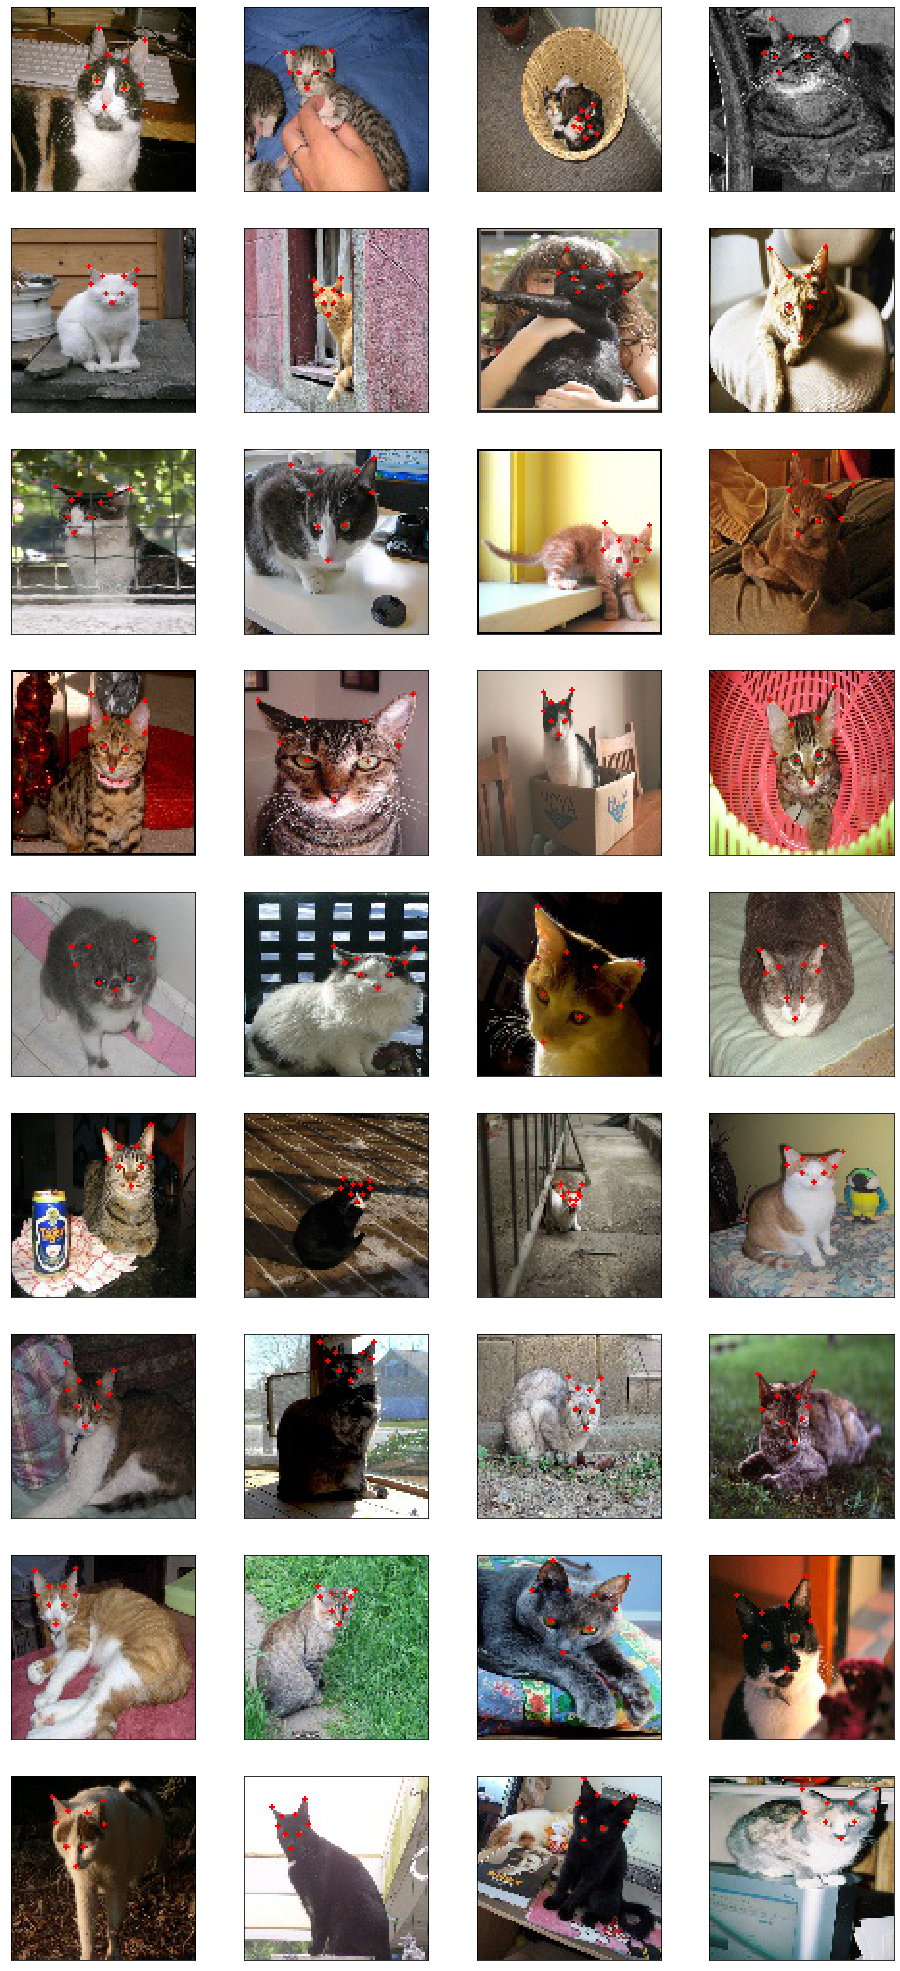

In [164]:
#plot_landmarks(s, model.valid_res_tbl, targets=keypoints_names, image_list=range(27), n_col=3)
plot_landmarks(s, model.valid_res_tbl, targets=keypoints_names, image_list=range(36), n_col=4)

**Задание 7 (дополнительное):**<br><br>
Перепишите функцию plot_landmarks так, чтобы различные ключевые точки отображались различными цветами. То есть, например, точка левого глаза всегда была синей, правого - зеленой и т.д.

In [ ]:
#Ваш код здесь